<a href="https://colab.research.google.com/github/ImanLiao/COMP3029-ComputerVision/blob/main/COMP3029_Lab04_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook is prepared by Dr. Iman Yi Liao.
The main objective of the lab session is as follows.
1. To create Oil Palm Seeds dataset with Dataset class in PyTorch
2. To load Oil Palm Seeds dataset in memory with Dataloader class in PyTorch
3. To create a simple CNN to perform image classification 

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
%cd /content/drive/My Drive/AAR

/content/drive/My Drive/AAR


# Install Necessary Libraries

In [3]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 95kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 12.6MB/s 


# Create Oil Palm Seeds Dataset
Use **Dataset** class in PyTorch to create the oil palm seeds dataset and use **DataLoader** class in PyTorch to load dataset in minibatches.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

Define the oil palm seeds dataset

In [22]:
import os
import pandas as pd
from torchvision.io import read_image

class OilPalmSeedsDataset(Dataset):
    def __init__(self, df, base_path, transform=None, target_transform=None):
        self.df = df
        self.base_path = base_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx, 1]

        # The training images are stored in two separate folders
        if label == 1:
          img_path = os.path.join(self.base_path, 'GoodSeed/', self.df.iloc[idx, 0])
        elif label == 0:
          img_path = os.path.join(self.base_path, 'BadSeed/', self.df.iloc[idx, 0])
        image = read_image(img_path)
        # print(image.shape)
        #image = transforms.ToTensor() # convert ndarray to tensor
        #label = transforms.ToTensor() 

        # if any transformation is needed, e.g., to resize the image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        sample = {"image": image, "label": label}
        return sample

## Define the transformations you need to perform on images
If you need to resize the height and width of an image, randomly crop anf flip it, normalise each channel of the image, you can use torchvision.transforms.

In [23]:
# Note that the following transforms are not necessarily applicable to the raw images in our oil palm seeds dataset
# You will have to do something more appropriate and relevant
transform = transforms.Compose(
        [transforms.Resize([256, 256]),
         transforms.RandomCrop(224),
         transforms.RandomHorizontalFlip(),
         #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)), # mean, variance
         #transforms.ToTensor()
         ])

Create the training and testing dataset

In [24]:
import numpy as np

# load the training csv file in terms of annotations to dataframe and randomly split it to training and validation sets respectively
trainvaldf = pd.read_csv("trainingdata.csv")
traindf, valdf = np.split(trainvaldf.sample(frac=1, random_state=42), [int(.8*len(trainvaldf))])
base_path = '/content/drive/My Drive/AAR/seed/'

# Create training and validation dataset with OilPalmSeedsDataset
train_dataset = OilPalmSeedsDataset(traindf, base_path=base_path, transform=transform)
val_dataset = OilPalmSeedsDataset(valdf, base_path=base_path, transform=transform)

print('training set', len(train_dataset))
print('val set', len(val_dataset))


training set 139
val set 35


In [25]:
# load the testing csv file as dataframe
testdf = pd.read_csv("testdata.csv")
test_dataset = OilPalmSeedsDataset(testdf, base_path=base_path, transform=transforms.Resize([224, 224]))
print('test set', len(test_dataset))

test set 40


AS Dataset retrieves images and labels one sample at a time, but we typically need to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)

We can access samples in DataLoader using iterable feature

torch.Size([8, 3, 224, 224])
torch.Size([8])


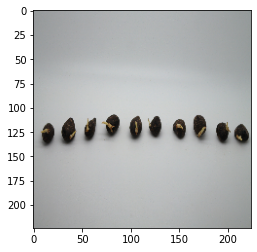

Label: 0


In [27]:
for i, sample in enumerate(train_dataloader):
  if i > 0:
    break
  print(sample['image'].size())
  print(sample['label'].size())
  plt.imshow(sample['image'][0].permute(1,2,0)) # change (C,H,W) to (H,W,C)
  plt.show()
  print(f"Label: {sample['label'][0]}")


# Define a simple CNN

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline 

In [29]:
import torch.nn as nn 
import torch.nn.functional as F 

We will define a class myCNN. It inherits from nn.Module and have two methods: an __init__() method and a forward() method. 

In [54]:
class myCNN(nn.Module): 
    def __init__(self, input_size): 
        super(myCNN,self).__init__()
        self.input_size = input_size # the input size of a single image (C,H,W)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(2,2)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5) 
        # The input number to the first fully connected layer is a bit tricky
        # We can run through a dummy forward pass to obtain the input number to the first fully connected layer
        dummydata = torch.rand(1, *self.input_size)
        dummydata = self.pool(F.relu(self.conv1(dummydata)))
        dummydata = self.pool(F.relu(self.conv2(dummydata)))
        self.num_features_2fc = dummydata.shape[0]*dummydata.shape[1]*dummydata.shape[2]*dummydata.shape[3] # there are clever ways but I don't recall them and need to search up
        self.fc1 = nn.Linear(in_features=self.num_features_2fc, out_features=120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_features_2fc)
        #x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation on final layer 
        return F.log_softmax(x)

model = myCNN(train_dataset[0]['image'].shape)

It's likely you will be using GPU for training process

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))
model.to(device)

Using cuda:0 device


myCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

# Train the model you've created with the oil palm dataset
Beware that the dataset is not processed to be effective for training. The following demonstratest the key components you will need for training process.

## Initialise model parameters
If you do nothing, the parameters will be initialised by PyTorch's default initialisation methods for [convolutional layer](https://github.com/pytorch/pytorch/blob/9cf62a4b5d3b287442e70c0c560a8e21d8c3b189/torch/nn/modules/conv.py#L111) and for [linear layer](https://github.com/pytorch/pytorch/blob/9cf62a4b5d3b287442e70c0c560a8e21d8c3b189/torch/nn/modules/linear.py#L168).

We will define initialisation methods other than the default. There are many other ways of initialising weights, e.g., for a single layer, and with your own specific value.

In [56]:
def initialize_weights(model):
  if isinstance(model, nn.Conv2d):
      nn.init.kaiming_uniform_(model.weight.data,nonlinearity='relu')
      if model.bias is not None:
          nn.init.constant_(model.bias.data, 0)
  elif isinstance(model, nn.BatchNorm2d):
      nn.init.constant_(model.weight.data, 1)
      nn.init.constant_(model.bias.data, 0)
  elif isinstance(model, nn.Linear):
      nn.init.kaiming_uniform_(model.weight.data)
      nn.init.constant_(model.bias.data, 0)

We now apply the initialisation methods to the model.

In [57]:
model.apply(initialize_weights)

myCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Loss function and optimisation

We define the loss function as cross-entropy for classification problems. We use stochastic gradient descent optmisation method for error back propagation.

In [58]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

During training we need to keep track of the loss function value. We also have to evaluate the performance at each epoch with validation dataset.

In [46]:
data_lengths = {'train': len(train_dataset), 'val': len(val_dataset)}
print(data_lengths)

{'train': 139, 'val': 35}


In [63]:
from torch.autograd import Variable

# Training with Validation 
n_epochs = 2 # just to test the code
data_loaders = {'train': train_dataloader, 'val': val_dataloader}
data_lengths = {'train': len(train_dataset), 'val': len(val_dataset)}

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            #optimizer = scheduler(optimizer, epoch)
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:

            # get the input images and their corresponding labels
            images = data['image']
            labels = data['label']

            # wrap them in a torch Variable
            images, labels = Variable(images), Variable(labels)

            # convert variables to floats for regression loss
            labels = labels.type(torch.LongTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_labels = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_labels, labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 0/1
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 866070033.6260
val Loss: 0.0987
Epoch 1/1
----------
train Loss: 0.0901
val Loss: 0.0990


## Prediction

Once the model is trained, it is good practice to save the model parameters.

In [64]:
for param in model.state_dict():
    print(param, "\t", model.state_dict()[param].size())

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 44944])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([2, 84])
fc3.bias 	 torch.Size([2])


In [66]:
fname = '/content/drive/My Drive/AAR/myModel.pkl'
torch.save(model.state_dict(), fname)

Now load the saved model

In [68]:
loaded_dict = torch.load(fname)
model.load_state_dict(loaded_dict)
model.eval()

myCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

We can now use the trained model to predict on our testing dataset.

In [71]:
total = 0  # keeps track of how many images we have processed 
correct = 0  # keeps track of how many correct images our model predicts
with torch.no_grad():
    for i, data in enumerate(test_dataloader): 
        images = data['image']
        labels = data['label']

        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)

        # convert variables to floats for regression loss
        labels = labels.type(torch.LongTensor).to(device)
        images = images.type(torch.FloatTensor).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size()[0]
        correct += (predicted == labels).sum().item()
    
print("Accuracy: ", correct/total)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy:  0.5
